In [37]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset as TorchDataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.transforms import Compose
import matplotlib.pyplot as plt

In [39]:
# Define Label class
from collections import namedtuple

Label = namedtuple('Label', ['name', 'id', 'trainId', 'category', 'catId', 'hasInstances', 'ignoreInEval'])

# Define your labels
labels = [
     #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   
     Label(  'unlabeled'            ,  0 ,      20 , 'void'            , 0       , False        , True),
     Label(  'ego vehicle'          ,  1 ,      20 , 'void'            , 0       , False        , True),
     Label(  'rectification border' ,  2 ,      20 , 'void'            , 0       , False        , True),
     Label(  'out of roi'           ,  3 ,      20 , 'void'            , 0       , False        , True),
     Label(  'static'               ,  4 ,      20 , 'void'            , 0       , False        , True),
     Label(  'dynamic'              ,  5 ,      20 , 'void'            , 0       , False        , True),
     Label(  'ground'               ,  6 ,      20 , 'void'            , 0       , False        , True),
     Label(  'road'                 ,  7 ,        0 , 'ground'          , 1       , False        , False),
     Label(  'sidewalk'             ,  8 ,        1 , 'ground'          , 1       , False        , False),
     Label(  'parking'              ,  9 ,      20 , 'ground'          , 1       , False        , True),
     Label(  'rail track'           , 10 ,      20 , 'ground'          , 1       , False        , True),
     Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False),
     Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False),
     Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False),
     Label(  'guard rail'           , 14 ,      20 , 'construction'    , 2       , False        , True),
     Label(  'bridge'               , 15 ,      20 , 'construction'    , 2       , False        , True),
     Label(  'tunnel'               , 16 ,      20 , 'construction'    , 2       , False        , True),
     Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False),
     Label(  'polegroup'            , 18 ,      20 , 'object'          , 3       , False        , True),
     Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False),
     Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False),
     Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False),
     Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False),
     Label(  'sky'                  , 23 ,       20 , 'sky'             , 5       , False        , False),
     Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False),
     Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False),
     Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False),
     Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False),
     Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False),
     Label(  'caravan'              , 29 ,      20 , 'vehicle'         , 7       , True         , True),
     Label(  'trailer'              , 30 ,      20 , 'vehicle'         , 7       , True         , True),
     Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False),
     Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False),
     Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False),
     Label(  'license plate'        , 34 ,       19 , 'vehicle'         , 7       , False        , True )]

In [40]:
image_train_dir = 'processed_images'
label_train_dir = 'processed_masks'
image_val_dir = 'processed_val_images'
label_val_dir = 'processed__val_masks'
test_dir = 'processed_test_images'

print("Images Directory:", os.listdir(image_train_dir))

print("Labels Directory:", os.listdir(label_train_dir))

print("Images Directory:", os.listdir(image_val_dir))

print("Labels Directory:", os.listdir(label_val_dir))

print("Test Directory:", os.listdir(test_dir))

Images Directory: ['image_0.png', 'image_1.png', 'image_10.png', 'image_100.png', 'image_101.png', 'image_102.png', 'image_103.png', 'image_104.png', 'image_105.png', 'image_106.png', 'image_107.png', 'image_108.png', 'image_109.png', 'image_11.png', 'image_110.png', 'image_111.png', 'image_112.png', 'image_113.png', 'image_114.png', 'image_115.png', 'image_116.png', 'image_117.png', 'image_118.png', 'image_119.png', 'image_12.png', 'image_120.png', 'image_121.png', 'image_122.png', 'image_123.png', 'image_124.png', 'image_125.png', 'image_126.png', 'image_127.png', 'image_128.png', 'image_129.png', 'image_13.png', 'image_130.png', 'image_131.png', 'image_132.png', 'image_133.png', 'image_134.png', 'image_135.png', 'image_136.png', 'image_137.png', 'image_138.png', 'image_139.png', 'image_14.png', 'image_140.png', 'image_141.png', 'image_142.png', 'image_143.png', 'image_144.png', 'image_145.png', 'image_146.png', 'image_147.png', 'image_148.png', 'image_149.png', 'image_15.png', 'imag

In [41]:
# Function to create DataFrame
def create_dataframe(images_dir, labels_dir=None):
    image_files = sorted(os.listdir(images_dir))
    if labels_dir:
        label_files = sorted(os.listdir(labels_dir))
        # Create DataFrame with images and labels
        df = pd.DataFrame({
            'image': [os.path.join(images_dir, img) for img in image_files],
            'label': [os.path.join(labels_dir, lbl) for lbl in label_files]
        })
    else:
        # Create DataFrame with images only for the test set
        df = pd.DataFrame({
            'image': [os.path.join(images_dir, img) for img in image_files]
        })
    
    return df

In [42]:
# Create DataFrames for train, val, and test
df_train = create_dataframe(image_train_dir, label_train_dir)
df_val = create_dataframe(image_val_dir, label_val_dir)
df_test = create_dataframe(test_dir)

In [43]:
# Display the DataFrames
print("Training DataFrame:")
print(df_train.head())

print("\nValidation DataFrame:")
print(df_val.head())

print("\nTest DataFrame:")
print(df_test.head())

Training DataFrame:
                            image                         label
0    processed_images\image_0.png    processed_masks\mask_0.png
1    processed_images\image_1.png    processed_masks\mask_1.png
2   processed_images\image_10.png   processed_masks\mask_10.png
3  processed_images\image_100.png  processed_masks\mask_100.png
4  processed_images\image_101.png  processed_masks\mask_101.png

Validation DataFrame:
                                image                              label
0    processed_val_images\image_0.png    processed__val_masks\mask_0.png
1    processed_val_images\image_1.png    processed__val_masks\mask_1.png
2   processed_val_images\image_10.png   processed__val_masks\mask_10.png
3  processed_val_images\image_100.png  processed__val_masks\mask_100.png
4  processed_val_images\image_101.png  processed__val_masks\mask_101.png

Test DataFrame:
                                 image
0    processed_test_images\image_0.png
1    processed_test_images\image_1.png
2

In [44]:
transform = transforms.Compose([
    transforms.ToTensor()  # Convert image to tensor
])


In [45]:
def load_image(image_path):
    """
    Loads an image from the given path and returns it as a PIL Image or Tensor.
    """
    image = Image.open(image_path).convert("RGB")
    return image

In [46]:
def load_mask(mask_path):
    """
    Loads a mask from the given path and returns it as a PIL Image or Tensor.
    """
    mask = Image.open(mask_path).convert("L")
    return mask

In [47]:
def paths_to_images(df, has_mask=True):
    """
    Load images and masks from the given DataFrame.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing paths to images and masks.
        has_mask (bool): Indicates if masks are present in the DataFrame.
        
    Returns:
        image_list (list): List of image tensors.
        mask_list (list or None): List of mask tensors (None if no masks).
    """
    image_list = []
    mask_list = [] if has_mask else None
    
    for index, row in df.iterrows():
        # Load the image
        image = load_image(row['image'])
        image = transform(image)  # Transform the image (e.g., to tensor)
        
        image_list.append(image)
        
        # Load the mask only if it exists
        if has_mask:
            mask = load_mask(row['label'])
            mask = transform(mask)  # Transform the mask (e.g., to tensor)
            mask_list.append(mask)

    return image_list, mask_list

In [48]:
# Example usage
image_list, mask_list = paths_to_images(df_train)
val_image_list, val_mask_list = paths_to_images(df_val)
test_image_list, _ = paths_to_images(df_test, has_mask=False)


# You can now access images and masks
print(f"First image shape: {image_list[0].shape}")
print(f"First mask shape: {mask_list[0].shape}")
print(f"First image shape: {val_image_list[0].shape}")
print(f"First mask shape: {mask_list[0].shape}")

First image shape: torch.Size([3, 256, 256])
First mask shape: torch.Size([1, 256, 256])
First image shape: torch.Size([3, 256, 256])
First mask shape: torch.Size([1, 256, 256])


In [49]:
print(f"Number of items in image_list: {len(image_list)}")

Number of items in image_list: 300


In [50]:
mask_list

[tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 0.8627, 0.8627,  ..., 0.8627, 0.8627, 1.0000],
          [1.0000, 0.5843, 0.5843,  ..., 0.5843, 0.5843, 1.0000],
          ...,
          [1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
          [1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]]),
 tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.8235,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.4353,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]]),
 tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.7490,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.4941,  ...,

In [51]:
from torch.utils.data import Dataset, DataLoader

class TensorDataset(Dataset):
    def __init__(self, image_tensors, mask_tensors=None):
        self.images = image_tensors
        self.masks = mask_tensors  # Optional, if you have masks for segmentation tasks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if self.masks is not None:
            return self.images[idx], self.masks[idx]
        return self.images[idx]

In [52]:
train_dataset = TensorDataset(image_tensors=image_list, mask_tensors=mask_list)
val_dataset = TensorDataset(image_tensors=val_image_list, mask_tensors=val_mask_list)
test_dataset = TensorDataset(image_tensors=test_image_list)

In [53]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, 
                          num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, 
                        num_workers=0, pin_memory=True)

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, 
                         num_workers=0, pin_memory=True)

In [54]:
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 300
Validation dataset size: 380
Test dataset size: 595


In [55]:
# Get a batch from the DataLoader
for images, masks in train_loader:
    # Print shape, data type, and device for images
    print("Images Shape: ", images.shape)
    print("Images Data Type: ", images.dtype)
    print("Images Device: ", images.device)

    # Print shape, data type, and device for masks
    print("Masks Shape: ", masks.shape)
    print("Masks Data Type: ", masks.dtype)
    print("Masks Device: ", masks.device)
    
    break  # Exit after the first batch

Images Shape:  torch.Size([16, 3, 256, 256])
Images Data Type:  torch.float32
Images Device:  cpu
Masks Shape:  torch.Size([16, 1, 256, 256])
Masks Data Type:  torch.float32
Masks Device:  cpu


In [56]:
# Get one batch from the DataLoader
data_iter = iter(train_loader)  # Create an iterator from the DataLoader
images, masks = next(data_iter)  # Get the first batch of images and masks

In [57]:
# Convert tensors to numpy for plotting
images_np = images.numpy()
masks_np = masks.numpy()

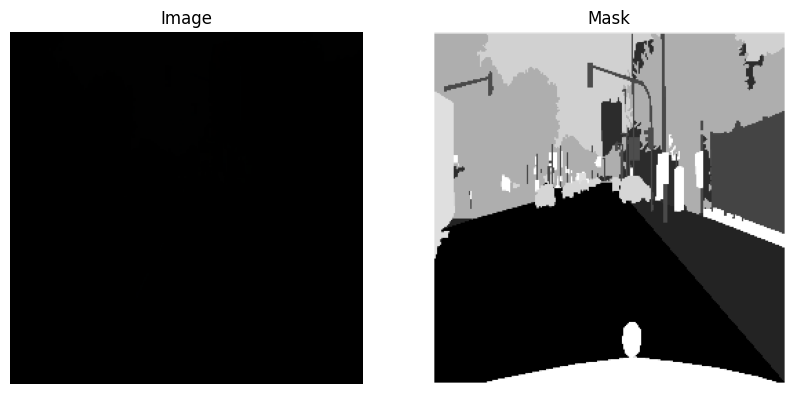

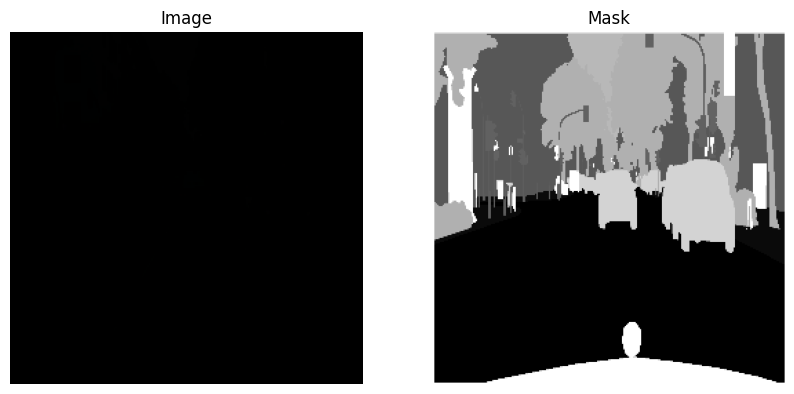

In [58]:
def visualize_from_dataloader(data_loader):
    """Visualize an image and its corresponding mask from the DataLoader."""
    # Get one batch of data
    images, masks = next(iter(data_loader))
    
    # Select the first image and mask from the batch
    image = images[0]  # Shape: (C, H, W)
    mask = masks[0]    # Shape: (C, H, W) or (H, W)
    
    # Convert image and mask for visualization
    image = image.numpy().transpose(1, 2, 0)  # (C, H, W) to (H, W, C)
    mask = mask.numpy().squeeze()  # Remove channel dimension if needed

    # Create a figure with 2 subplots
    plt.figure(figsize=(10, 5))
    
    # Display the image
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Image')
    plt.axis('off')  # Hide axes
    
    # Display the mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')  # Use cmap='gray' for grayscale
    plt.title('Mask')
    plt.axis('off')  # Hide axes

    plt.show()

# Call the function to visualize
visualize_from_dataloader(train_loader)
visualize_from_dataloader(val_loader)

Training

In [59]:
print(torch.cuda.is_available())

torch.cuda.get_device_name(0)

True


'NVIDIA GeForce RTX 3050 Ti Laptop GPU'

In [60]:
print(images.shape)

torch.Size([16, 3, 256, 256])


In [61]:
class UNet(nn.Module):
    def double_convolution(self, in_channels, out_channels):
        conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return conv_op

    def __init__(self, num_classes=20):  # Make sure this matches
        super(UNet, self).__init__()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)

        # Contracting path
        self.down_convolution_1 = self.double_convolution(3, 16)
        self.down_convolution_2 = self.double_convolution(16, 32)
        self.down_convolution_3 = self.double_convolution(32, 64)
        self.down_convolution_4 = self.double_convolution(64, 128)
        self.down_convolution_5 = self.double_convolution(128, 256)

        # Expanding path
        self.up_transpose_1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_convolution_1 = self.double_convolution(256, 128)

        self.up_transpose_2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_convolution_2 = self.double_convolution(128, 64)

        self.up_transpose_3 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.up_convolution_3 = self.double_convolution(64, 32)

        self.up_transpose_4 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.up_convolution_4 = self.double_convolution(32, 16)

        self.out = nn.Conv2d(16, num_classes, kernel_size=1)

    def forward(self, x):
        # Contracting path
        down_1 = self.down_convolution_1(x) 
        down_2 = self.max_pool2d(down_1) 
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3)
        down_5 = self.down_convolution_3(down_4) 
        down_6 = self.max_pool2d(down_5) 
        down_7 = self.down_convolution_4(down_6) 
        down_8 = self.max_pool2d(down_7)
        down_9 = self.down_convolution_5(down_8) 
        
        # Expanding path
        up_1 = self.up_transpose_1(down_9) 
        x = self.up_convolution_1(torch.cat([down_7, up_1], 1))
        up_2 = self.up_transpose_2(x)
        x = self.up_convolution_2(torch.cat([down_5, up_2], 1))
        up_3 = self.up_transpose_3(x)
        x = self.up_convolution_3(torch.cat([down_3, up_3], 1))
        up_4 = self.up_transpose_4(x) 
        x = self.up_convolution_4(torch.cat([down_1, up_4], 1)) 
        
        out = self.out(x) 
        return out


In [62]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create an instance of the UNet model
model = UNet(num_classes=20).to(device)  # Move model to the selected device

In [63]:
device = torch.device('cuda')

model = UNet(num_classes=20).to(device)

input = torch.randn(1, 3, 256, 256).to(device)

output = model(input)

print(output.shape)


torch.Size([1, 20, 256, 256])
